In [1]:
import scanpy as sc
import anndata as ann
import loompy as lo
import numpy as np 
import glob
import seaborn as sb
import pandas as pd
import scrublet as scr
import pickle

sc.settings.verbosity = 3

from matplotlib import rcParams
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/mm_pancreas_atlas_rep/code/')
import helper as h
from constants import SAVE

#R interface
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
%%R
library(scran)
library(RColorBrewer)
library(DropletUtils)
library(BiocParallel)

In [3]:
# Path for saving results - last shared folder by all datasets
shared_folder='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/'
#Path for loading individual samples
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse*/'
#Unique ID2 for reading/writing h5ad files with helper function
UID2='FltpAdult_pp'

## Load data (filtered)

In [4]:
# List all files
file_name='filtered_gene_bc_matrices.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas=[]
file_diffs=[]
for file in files:
    print('Reading file',file)
    #adatas.append(sc.read_h5ad(file))
    adatas.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata = ann.AnnData.concatenate( *adatas,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse1/filtered_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse2/filtered_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse4/filtered_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse3/filtered_gene_bc_matrices.h5ad


In [5]:
# Sample names
file_diffs

['mouse1', 'mouse2', 'mouse4', 'mouse3']

In [6]:
adata

AnnData object with n_obs × n_vars = 17763 × 31127
    obs: 'file'

Add sample design information

In [39]:
# Design of each sample
fltp_sort = {'mouse1' : 'neg', 'mouse2' : 'pos','mouse3' : 'neg','mouse4' : 'pos'}
region_sort = {'mouse1' : 'head', 'mouse2' : 'head','mouse3' : 'tail', 'mouse4' : 'tail'}
adata.obs['FVR']=[fltp_sort[file] for file in adata.obs.file]
adata.obs['region']=[region_sort[file] for file in adata.obs.file]

## Empty droplets and ambient gene expression

### Check that empty droplets were removed

N counts for cells that passed CellRanger filtering

In [7]:
# Visually check if empty cells are present
adata.obs['n_counts'] = adata.X.sum(axis = 1)

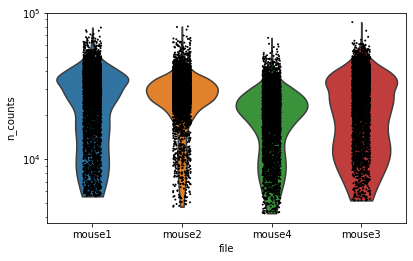

In [7]:
t1 = sc.pl.violin(adata, 'n_counts',
                  groupby='file',
                  size=2, log=True, cut=0)

In [ ]:
# Load raw data
# List all files
file_name='raw_gene_bc_matrices.h5ad'
files=glob.glob(path_data+file_name)
# Find which parts of file paths differ between files to later use them as file id
diff_path_idx=[]
for position in range(len(path_data.split('/'))):
    values=set([file.split('/')[position] for file in files])
    if len(values)>1:
        diff_path_idx.append(position)

# Load files and extract parts of file path that identifies the file, compared to other loaded files
adatas_raw=[]
file_diffs=[]
for file in files:
    print('Reading file',file)
    #adatas_raw.append(sc.read_h5ad(file))
    adatas_raw.append(h.open_h5ad(file=file,unique_id2=UID2))
    file_diffs.append('_'.join([file.split('/')[i] for i in diff_path_idx]))
    
adata_raw = ann.AnnData.concatenate( *adatas_raw,  batch_key = 'file', batch_categories = file_diffs).copy()    

Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse1/raw_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse2/raw_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse4/raw_gene_bc_matrices.h5ad
Reading file /lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/islet_fltp_headtail/rev4/scanpy_AnnData/mouse3/raw_gene_bc_matrices.h5ad


In [ ]:
adata_raw

In [ ]:
adata_raw.obs['n_counts'] = adata_raw.X.sum(1)

In [12]:
# Find drops removed by CellRanger
filtered_drops=~adata_raw.obs.index.isin(adata.obs.index)
print('N drops filtered out as empty:',filtered_drops.sum(),
      'out of all drops:',adata_raw.shape[0],'-> remaining:',adata.shape[0])

N drops filtered out as empty: 2931357 out of all drops: 2949120 -> remaining: 17763


Distribution of N counts of drops that were removed by CellRanger

Trying to set attribute `.uns` of view, copying.


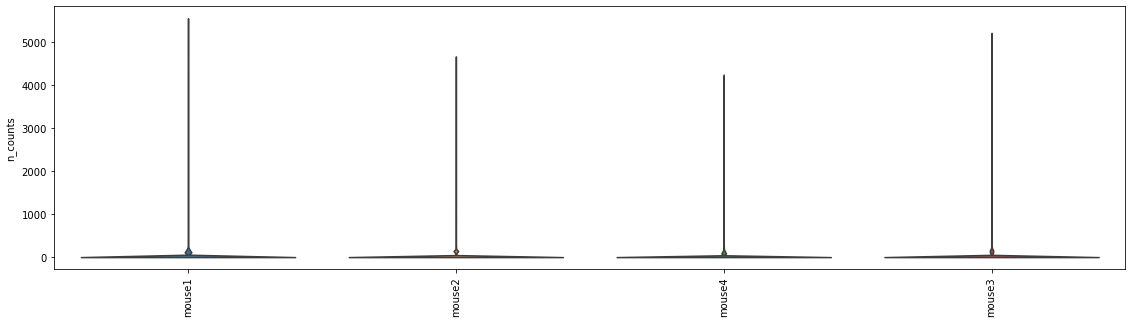

In [13]:
# Plot n_counts of drops that were removed by CellRanger
rcParams['figure.figsize']= (15,5)
sc.pl.violin(adata_raw[filtered_drops], ['n_counts'], groupby='file', size=1, log=False,rotation=90,stripplot=False)

In [14]:
print('N cells per non-filtered sample')
adata_raw.obs['file'].value_counts()

N cells per non-filtered sample


mouse3    737280
mouse4    737280
mouse2    737280
mouse1    737280
Name: file, dtype: int64

In [ ]:
#Remove empty genes and cells
sc.pp.filter_cells(adata_raw, min_counts=1)
sc.pp.filter_genes(adata_raw, min_cells=1)

In [14]:
adata_raw

AnnData object with n_obs × n_vars = 2170037 × 22249
    obs: 'file', 'n_counts'
    var: 'n_cells', 'mean_ambient_n_counts', 'mean_ambient_n_counts_mouse1', 'mean_ambient_n_counts_mouse2', 'mean_ambient_n_counts_mouse4', 'mean_ambient_n_counts_mouse3'

Cell N counts sorted by cell N counts rank without all 0 cells. 

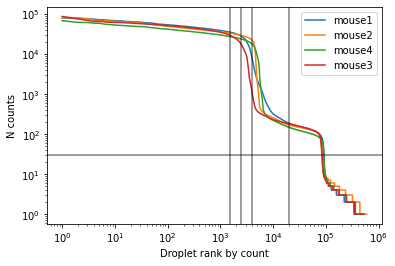

In [14]:
# For each file plot N count vs cell rank by count with log axes
fig, ax=plt.subplots()
for file in adata_raw.obs.file.unique():
    adata_raw_sub=adata_raw[adata_raw.obs.file==file,:].copy()
    plt.plot(list(range(1,adata_raw_sub.shape[0]+1)),adata_raw_sub.obs.n_counts.sort_values(ascending=False),
            label=file)
del adata_raw_sub
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Droplet rank by count')
plt.ylabel('N counts')
ax.axvline(1500,c='k',alpha=0.5)
ax.axvline(2500,c='k',alpha=0.5)
ax.axvline(4000,c='k',alpha=0.5)
ax.axvline(20000,c='k',alpha=0.5)
ax.axhline(30,c='k',alpha=0.5)

### Compute ambient genes

Compute ambient genes with emptyDrops and based on mean expression in low count droplets across all samples.

In [16]:
# Prepare data for emptyDrops
sparse_mat = adata_raw.X.T
genes = adata_raw.var_names
barcodes = adata_raw.obs_names

In [17]:
%%R -i sparse_mat -i genes -i barcodes -o ambient_scores
# Run emptyDrops and output scores per gene
sce <- SingleCellExperiment(assays = list(counts = sparse_mat), colData=barcodes)
rownames(sce) <- genes 
ambient <- emptyDrops(counts(sce),BPPARAM=MulticoreParam(workers = 16))
#is_cell <- ambient$FDR <= 0.05
#threshold_ambient <- 0.005
#ambient_genes <- names(ambient@metadata$ambient[ambient@metadata$ambient> threshold_ambient,])
ambient_scores <- as.data.frame(ambient@metadata$ambient)
#barcodes_filtered <- barcodes[which(is_cell)]

emptyDrops top ambient genes with scores.

In [18]:
ambient_scores.columns=['ambient_score']
ambient_scores.sort_values('ambient_score',ascending=False).query('ambient_score>=0.005')

,ambient_score
Ins2,0.317988
Ins1,0.119043
Iapp,0.057597
Gcg,0.033645
Malat1,0.014708
Ppy,0.012544
mt-Co3,0.009679
mt-Atp6,0.007777
mt-Co1,0.006312
Ttr,0.006283


Genes with highest mean expression in empty droplets (n_counts < 100, similar to emptyDrops).

In [15]:
ambient_vars=['mean_ambient_n_counts']
adata_raw.var['mean_ambient_n_counts']=adata_raw[adata_raw.obs['n_counts']<100].X.mean(0).A1
adata_raw.var['mean_ambient_n_counts'].sort_values(ascending=False)[:20]

index
Ins2       1.734248
Ins1       0.655944
Iapp       0.315745
Gcg        0.184520
Malat1     0.081240
Ppy        0.069128
mt-Co3     0.053627
mt-Atp6    0.043043
mt-Co1     0.035024
Ttr        0.034428
Mt1        0.032321
Pyy        0.028138
mt-Cytb    0.024265
Chga       0.024132
Sst        0.022473
mt-Co2     0.021852
mt-Nd1     0.017472
Rpl41      0.014977
Mt2        0.014796
Ftl1       0.013092
Name: mean_ambient_n_counts, dtype: float32

#C: The two gene lists are very similar for top genes.

Compute ambient genes for each sample based on mean expression in empty droplets.

In [16]:
# Mean empty expression in individual samples
for file in adata_raw.obs.file.cat.categories:
    adata_raw.var['mean_ambient_n_counts_' + file] = adata_raw[(adata_raw.obs.file == file) & (adata_raw.obs['n_counts']<100)
                                                  ].X.mean(0).A1
    ambient_vars.append('mean_ambient_n_counts_' + file)
    
# Top genes in individual samples    
ambient_genes = set()
for file in adata_raw.obs.file.cat.categories:
    ambient_file = list(adata_raw.var['mean_ambient_n_counts_' + file][
        np.flip(np.argsort(adata_raw.var['mean_ambient_n_counts_' + file]))].index)
    ambient_genes.update(ambient_file)

Mean ambient expression in individual samples divided by total mean ambient expression of individual samples. Ordered by combined smples, including top 20 ambient genes from each comparison.

In [17]:
# normalise ambient scores
ambient_df=adata_raw.var[ambient_vars]
ambient_df=ambient_df.loc[ambient_genes,ambient_vars]/ambient_df.sum(axis=0)

<AxesSubplot:ylabel='index'>

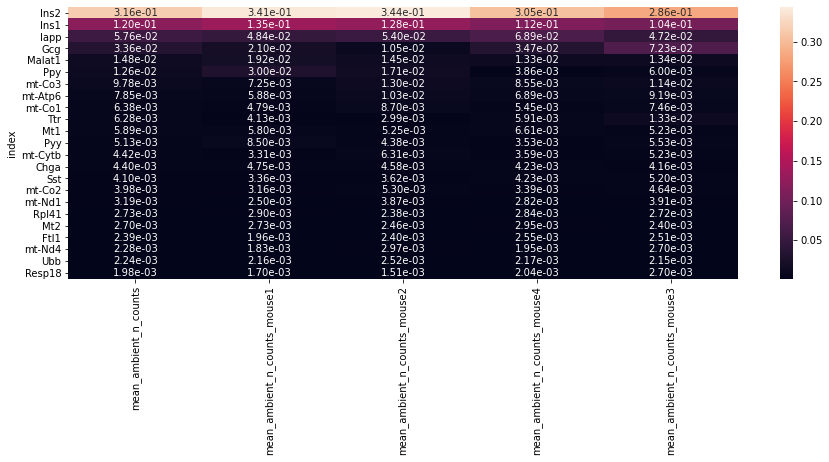

In [21]:
# Display ambient genes across samples
sb.heatmap(ambient_df.sort_values('mean_ambient_n_counts',ascending=False).iloc[:20,:],annot=True,fmt='.2e')

In [18]:
# Save ambient DF for top N genes
if SAVE:
    ambient_df.to_csv(shared_folder+"ambient_genes_topN_scores.tsv",sep='\t')

In [23]:
# Save genes with scaled mean ambient expression at least > 0.005 in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>0.005).any(axis=1)].index)

print('Selected ambient genes:',ambient_genes_selection)
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection.pkl", "wb" ) )

Selected ambient genes: ['Ttr', 'Malat1', 'Mt1', 'Ins1', 'mt-Co1', 'mt-Cytb', 'Sst', 'mt-Co3', 'Iapp', 'Ins2', 'Gcg', 'mt-Co2', 'Pyy', 'mt-Atp6', 'Ppy']


In [ ]:
#### Proportion of ambience based on ambient threshold
#All calculations are based on removing ambient genes from single sample, except for the plot line 
#"N removed genes across samples" that represents N removed genes at threshold across all samples

In [19]:
# Calculate retained ambient proportion and sum(abs(ambient_mean_geneI-ambient_sample_geneI))
# for ambient gene removal thresholds. Ambient genes are removed per sample.
thresholds=list(1/np.logspace(1,18,num=300,base=2,dtype='int'))
ambient_diffs=pd.DataFrame(columns=adata_raw.obs.file.unique())
removed_genes=pd.DataFrame(columns=list(adata_raw.obs.file.unique())+['all'])
ambient_proportions=pd.DataFrame(columns=adata_raw.obs.file.unique())
for idx,threshold in enumerate(thresholds):
    ambient_df_sub=ambient_df[~(ambient_df>threshold).any(axis=1)]
    removed_genes.at[idx,'all']=adata_raw.shape[1]-ambient_df_sub.shape[0]
    for sample in adata_raw.obs.file.unique():
        ambient_df_sub=ambient_df[~(ambient_df['mean_ambient_n_counts_'+sample]>threshold)]
        removed_genes.at[idx,sample]=adata_raw.shape[1]-ambient_df_sub.shape[0]
        diff=abs(ambient_df_sub['mean_ambient_n_counts']-ambient_df_sub['mean_ambient_n_counts_'+sample]).sum()
        ambient_diffs.at[idx,sample]=diff
        ambient_proportions.at[idx,sample]=ambient_df_sub['mean_ambient_n_counts_'+sample].sum()

In [34]:
AMBIENT_THR=0.0007

In [35]:
#Difference between mean and per sample ambient scores for retained genes
#and N removed genes across samples

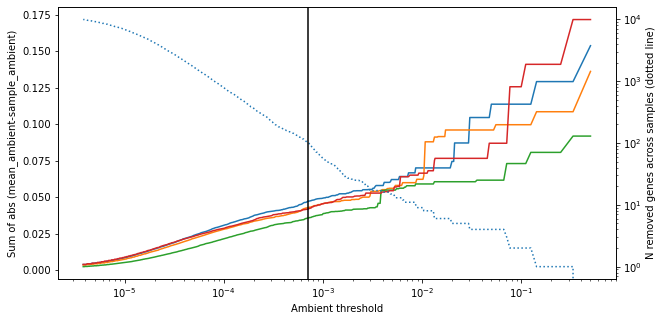

In [36]:
# Difference to average ambient scores for retained genes at each threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
ax2 = ax.twinx()  
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_diffs[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of abs (mean_ambient-sample_ambient)')
ax.set_xlabel('Ambient threshold')
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [32]:
#Retained ambient proportion per sample
#and N removed genes across samples

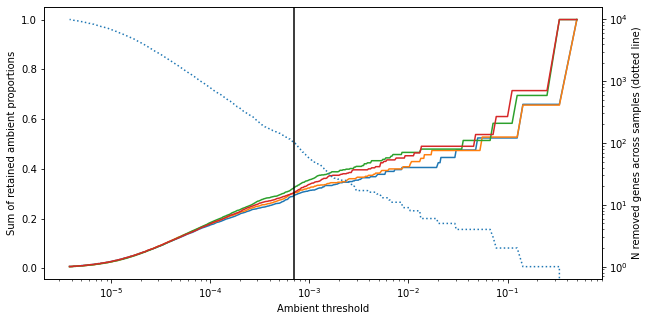

In [37]:
# Retained ambience per sample vs threshold
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,ambient_proportions[sample])
ax.set_xscale('log')
ax.set_ylabel('Sum of retained ambient proportions')
ax.set_xlabel('Ambient threshold')
ax2 = ax.twinx()  
ax2.plot(thresholds,removed_genes['all'],linestyle='dotted')
ax2.set_yscale('log')
ax2.set_ylabel('N removed genes across samples (dotted line)')
plt.axvline(AMBIENT_THR,c='k')

In [25]:
#N removed genes per sample

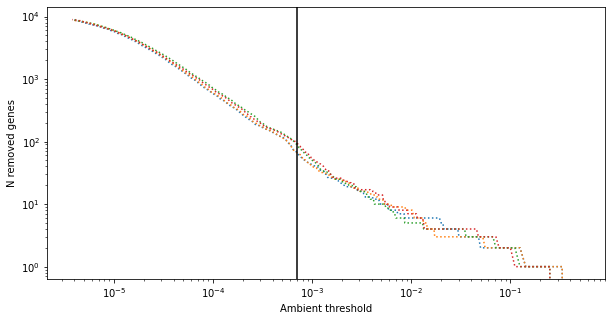

In [38]:
# N removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    ax.plot(thresholds,removed_genes[sample],linestyle='dotted')
ax.set_xscale('log')
ax.set_ylabel('N removed genes')
ax.set_xlabel('Ambient threshold')
ax.set_yscale('log')
plt.axvline(AMBIENT_THR,c='k')

In [27]:
#Removed ambience proportion divided by removed genes per sample

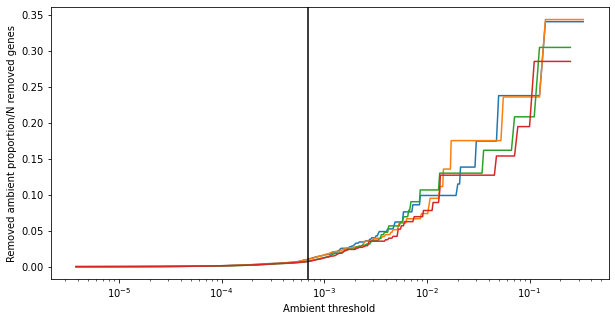

In [39]:
# Comparison of removed ambience vs N of removed genes per sample
rcParams['figure.figsize']= (10,5)
fig,ax=plt.subplots()
for sample in adata_raw.obs.file.unique():
    any_removed=np.array(removed_genes[sample])>0
    ax.plot(np.array(thresholds)[any_removed],((1-ambient_proportions[sample])/removed_genes[sample])[any_removed])
ax.set_xscale('log')
ax.set_ylabel('Removed ambient proportion/N removed genes')
ax.set_xlabel('Ambient threshold')
plt.axvline(AMBIENT_THR,c='k')

In [40]:
# Save genes with scaled mean ambient expression at least > threshold in any sample - 
# use the same genes for each sample so that further prrocessing (cell type annotation, embedding) can be done jointly
# !!! Check on heatmap that all such genes were included in the filtered 20 genes
ambient_genes_selection=list(ambient_df[(ambient_df>AMBIENT_THR).any(axis=1)].index)

print('N selected ambient genes:',len(ambient_genes_selection))
if SAVE:
    pickle.dump( ambient_genes_selection, open( shared_folder+"ambient_genes_selection_extended.pkl", "wb" ) )

N selected ambient genes: 103


In [ ]:
del adata_raw

## QC (counts, genes, mt)

In [8]:
# Add other QC metrics

#adata.obs['n_counts'] = adata.X.sum(axis = 1)
#adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(axis = 1)

mt_gene_mask = np.flatnonzero([gene.startswith('mt-') for gene in adata.var_names])
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['mt_frac'] = np.sum(adata[:, mt_gene_mask].X, axis=1).A1/adata.obs['n_counts']

### QC on UMAP 
Data used for UMAP: Total count normalised data with log transformation and PC preprocessing. UMAP distances are based on correlation.

In [9]:
# Preprocess data for UMAP
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Gcg', 'Cxcl2', 'Iapp', 'Apoe', 'Hbb-bs', 'Ins2', 'Mt2', 'Hba-a1', 'Hba-a2', 'Ccl2', 'Ccl4', 'Ppy', 'Pyy', 'Chga', 'Sst', 'Ttr', 'Cd74', 'Malat1', 'Fth1', 'Ins1', 'mt-Co1', 'mt-Atp6', 'mt-Co3']
    finished (0:00:00)


computing PCA
    with n_comps=15
    finished (0:00:17)


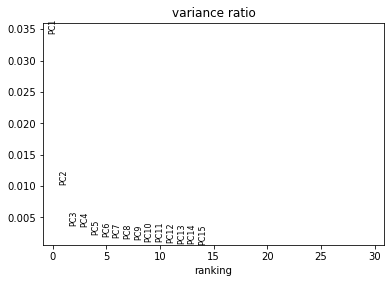

In [10]:
# Select number of PCs to use for UMAP
sc.pp.pca(adata_pp,n_comps=15,use_highly_variable =False)
sc.pl.pca_variance_ratio(adata_pp)

In [11]:
# Compute UMAP
sc.pp.neighbors(adata_pp, n_neighbors=15, n_pcs=11, metric='correlation')
sc.tl.umap(adata_pp)

computing neighbors
    using 'X_pca' with n_pcs = 11
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


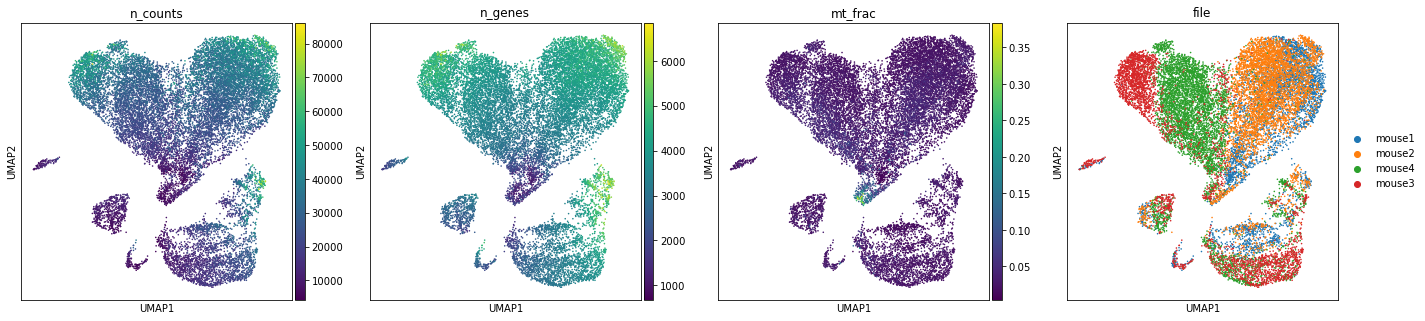

In [12]:
# Plot UMAP
rcParams['figure.figsize']=(5,5)
#TODO File was not plotted
sc.pl.umap(adata_pp, color=['n_counts','n_genes','mt_frac','file'],size=10)

... storing 'FVR' as categorical
... storing 'region' as categorical


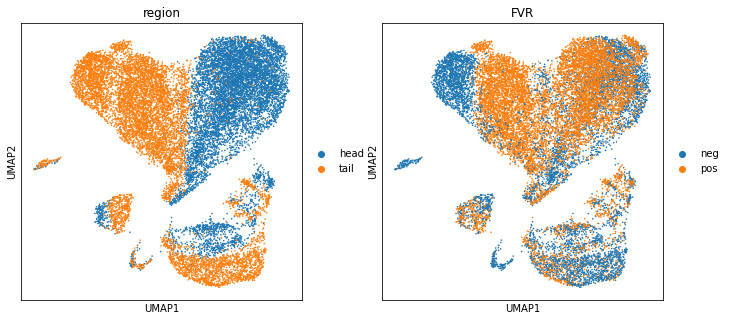

In [42]:
sc.pl.umap(adata_pp, color=['region','FVR'],size=10)

#C: There are somee subpopulations that have low counts and genes, but not high mt fraction. There are prominent batch effects between samples (due to region and possibly due to FVR sorting as well).

### QC - select thresholds

Check:
- joint distribution of N genes, N counts, and mt fraction
- distribution of metrics across samples

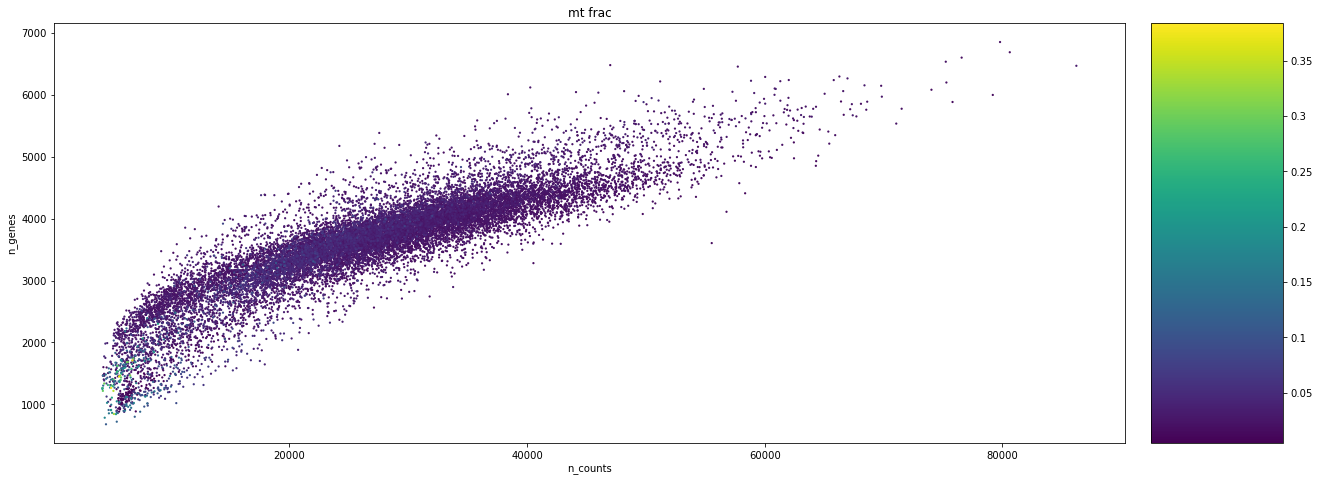

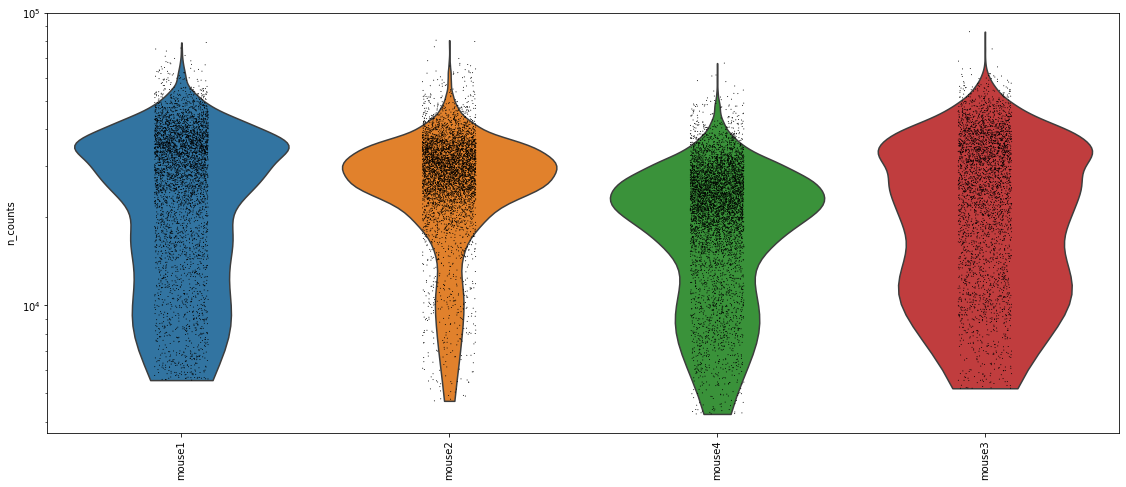

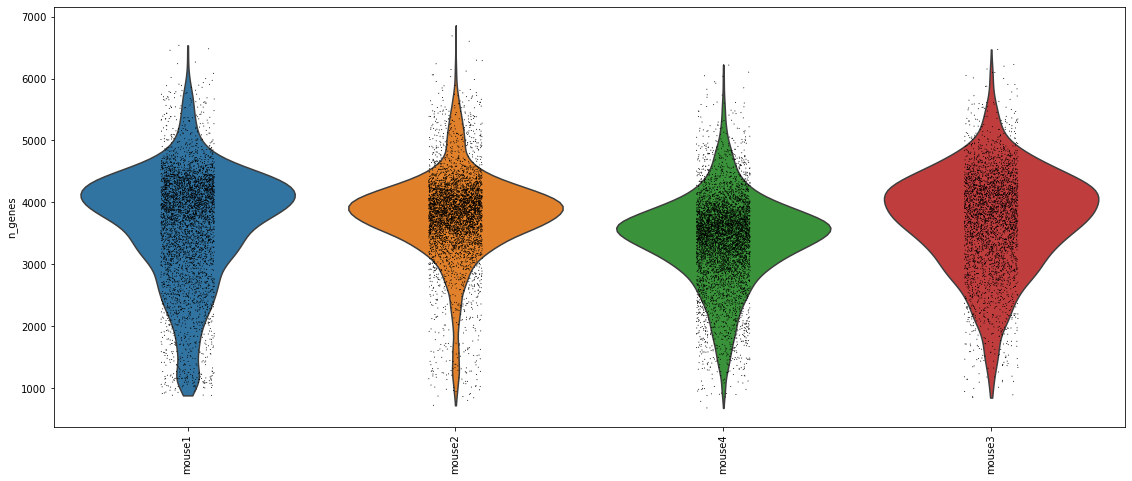

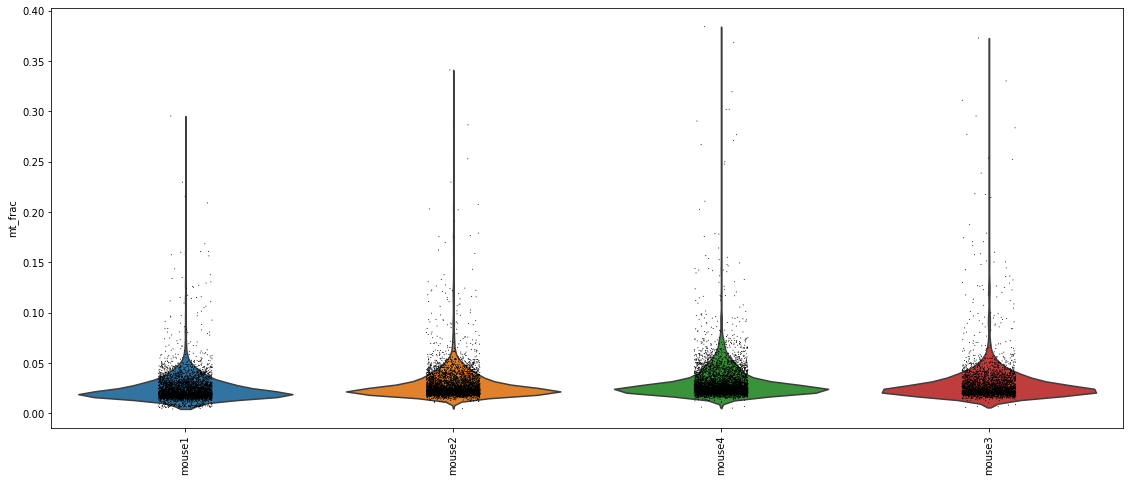

In [13]:
#Data quality summary plots
rcParams['figure.figsize']=(15,8)
p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac', size=20)
sc.pl.violin(adata, ['n_counts'], groupby='file', size=1, log=True,rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='file', size=1, log=False,rotation=90)
sc.pl.violin(adata, ['mt_frac'], groupby='file', size=1, log=False,rotation=90)

#C: There are some differences in n_counts between samples. Other metrics are consistent. There seems to be low n genes and n counts subpopulation with low mt fraction.

Trying to set attribute `.obs` of view, copying.
... storing 'FVR' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'region' as categorical


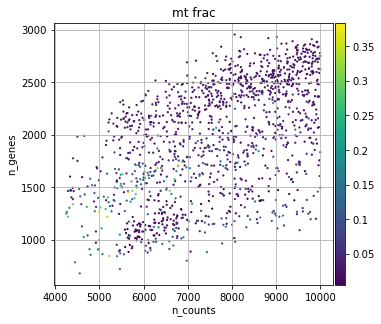

In [56]:
p1 = sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<3000, adata.obs['n_counts']<10000)], 'n_counts', 'n_genes', color='mt_frac', size=20,show=False)
p1.grid()
plt.show()

N counts:

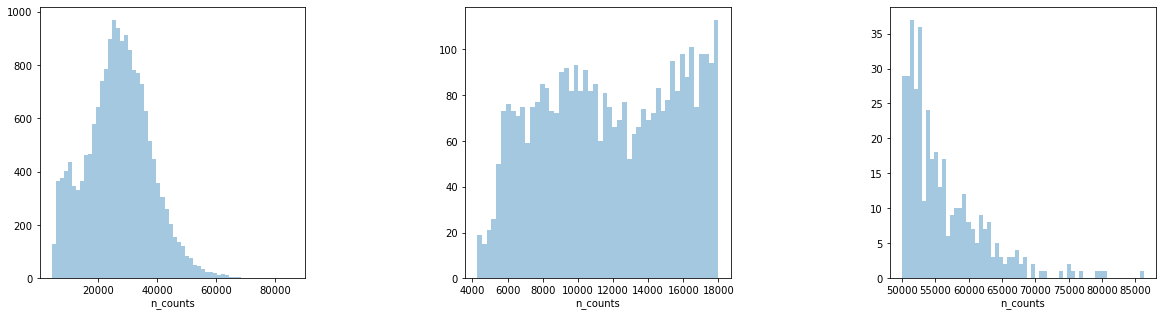

In [28]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p3 = sb.distplot(adata.obs['n_counts'], 
                 kde=False, 
                 ax=fig.add_subplot(fig_ind[0]), bins=60)
#p3.set_xscale('log')
p4 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']<18000], 
                 kde=False, bins=50, 
                 ax=fig.add_subplot(fig_ind[1]))
#p4.set_xscale('log')
p5 = sb.distplot(adata.obs['n_counts'][adata.obs['n_counts']>50000], 
                 kde=False, bins=60, 
                 ax=fig.add_subplot(fig_ind[2]))
plt.show()

N genes:

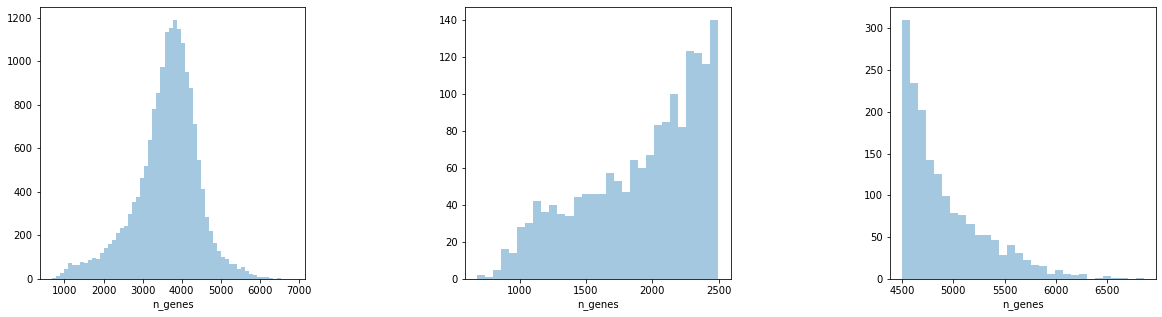

In [17]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 134)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.obs['n_genes'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p7 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']<2500], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[1]))
p8 = sb.distplot(adata.obs['n_genes'][adata.obs['n_genes']>4500], 
                 kde=False, bins=30, ax=fig.add_subplot(fig_ind[2]))
plt.show()

MT fraction:

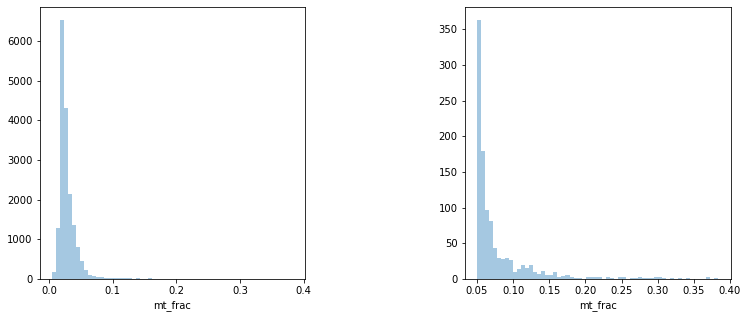

In [18]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

p8 = sb.distplot(adata.obs['mt_frac'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p9 = sb.distplot(adata.obs['mt_frac'][adata.obs['mt_frac']>0.05], 
                 kde=False, bins=60, ax=fig.add_subplot(fig_ind[1]))
plt.show()

For cells that have too low/high metrics show location on UMAP.

In [19]:
def assign_high_low(adata,obs_col,low,high):
    """
    Add low/high annotation to each cell for a metric. 
    Add obs column specifying if cell has ok/low/high value (categories ordered in this order) and uns color map - 
    gray for ok, blue for low, red for high.
    New obs columns is named obs_col_filter and colourmap is named obs_col_filter_colors.
    :param adata: anndata object that contains column with metric to be filtered and to which filter result column
    and colur map are added
    :param obs_col: obs column on which to perform filtering
    :param low: low - cells that have obs_col value < low are assigned 'low'
    :param high: high - cells that have obs_col value > high are assigned 'high'
    """
    cell_type=[]
    for val in adata.obs[obs_col]:
        if val>high:
            cell_type.append('high')
        elif val<low:
            cell_type.append('low')
        else:
            cell_type.append('ok')
    adata.obs[obs_col+'_filter']=cell_type
    adata.obs[obs_col+'_filter']=adata.obs[obs_col+'_filter'].astype('category')
    # So that low and high are plotted on top
    adata.obs[obs_col+'_filter'].cat.reorder_categories(
        [category for category in ['ok','low','high'] if category in adata.obs[obs_col+'_filter'].cat.categories], inplace=True)
    type_col={'high':'#e62e0e','low':'#02c6ed','ok':'#a8a8a8'}
    col_list=[]
    for filter_type in adata.obs[obs_col+'_filter'].cat.categories:
        col_list.append(type_col[filter_type])
    adata.uns[obs_col+'_filter_colors']=col_list

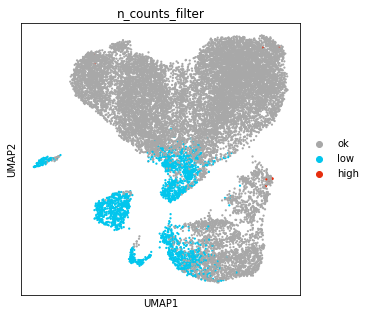

In [27]:
param='n_counts'
rcParams['figure.figsize']=(5,5)
COUNTS_THR_MIN=13000
COUNTS_THR_MAX=70000
assign_high_low(adata=adata,obs_col=param,low=COUNTS_THR_MIN,high=COUNTS_THR_MAX)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

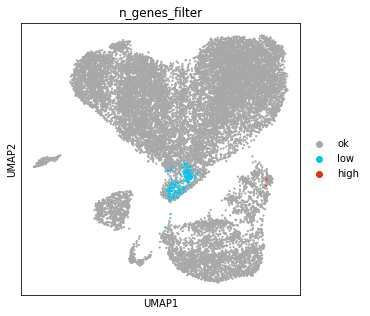

In [49]:
param='n_genes'
rcParams['figure.figsize']=(5,5)
GENES_THR_MIN=1400
GENES_THR_MAX=6300
assign_high_low(adata=adata,obs_col=param,low=GENES_THR_MIN,high=GENES_THR_MAX)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=20)

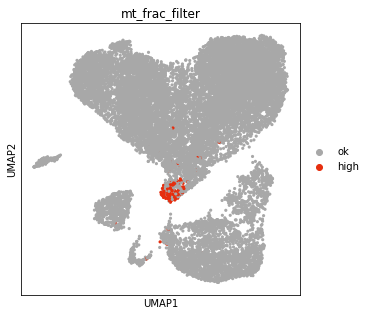

In [32]:
param='mt_frac'
MT_THR=0.1 # Initially was set to 0.2
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-1,high=MT_THR)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp, color=[param+'_filter'],size=40)

#C: Filtering out high N genes and N counts cells does not seem to be very important yet.

#C: There are evident subpopulations that have relatively low N counts but ok N genes and MT fraction metrics. Thus N counts will not be used for filtering - instead a more stringent mt fraction threshold was selected. N genes would also filter out a small subpopulation without high mt fraction, thus it will not be used.

N cells in which a gene is expressed:

In [43]:
adata.var['n_cells']=(adata.X > 0).sum(axis = 0).T

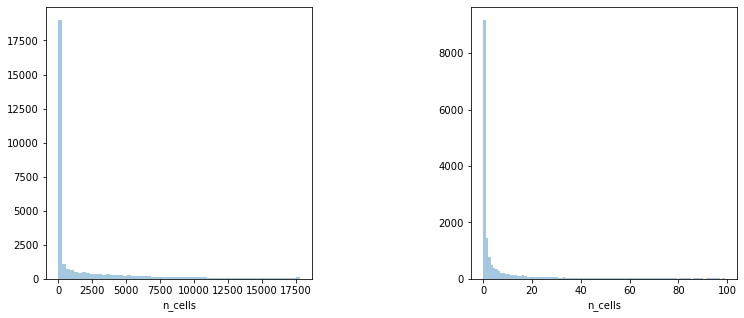

<AxesSubplot:xlabel='n_cells'>

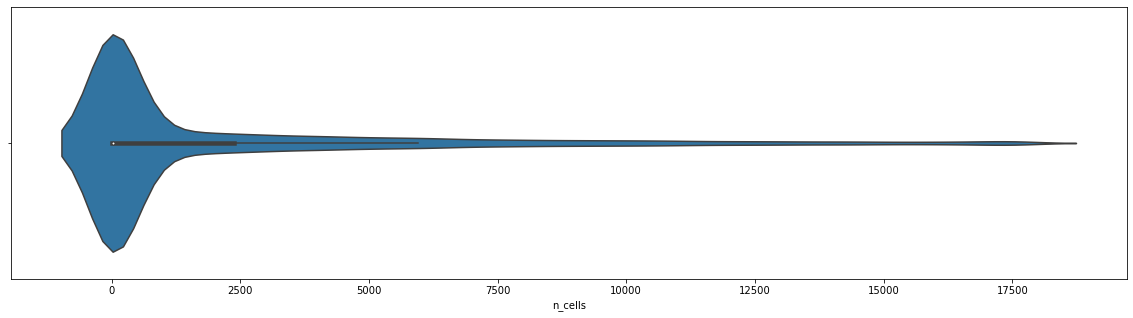

In [44]:
rcParams['figure.figsize']=(20,5)
fig_ind=np.arange(131, 133)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6) #create a grid for subplots

p6 = sb.distplot(adata.var['n_cells'], kde=False, bins=60, ax=fig.add_subplot(fig_ind[0]))

p8 = sb.distplot(adata.var['n_cells'][adata.var['n_cells']<100], 
                 kde=False, bins=100, ax=fig.add_subplot(fig_ind[1]))
plt.show()
sb.violinplot(adata.var['n_cells'] )

Filter out genes and cells

In [57]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

# Do not perform min count filtering
#sc.pp.filter_cells(adata, min_counts = COUNTS_THR_MIN)
#print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs['mt_frac'] <= MT_THR]
print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

# Do not perform min N genes filtering
#sc.pp.filter_cells(adata, min_genes = GENES_THR_MIN)
#print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 17763
Number of cells after MT filter: 17584


In [58]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

CELLS_THR_MIN=20
# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=CELLS_THR_MIN)
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 31127
filtered out 14682 genes that are detected in less than 20 cells


Trying to set attribute `.var` of view, copying.


Number of genes after cell filter: 16445


## Doublet filtering

Perform doublet filtering with Scrublet per sample.

In [59]:
adata.obs['doublet_score']=np.zeros(adata.shape[0])
adata.obs['doublet']=np.zeros(adata.shape[0])

# filtering/preprocessing parameters:
min_counts = 3
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.05 
sim_doublet_ratio = 2
n_neighbors = None #If `None`, this is set to round(0.5 * sqrt(n_cells))

# Detect doublets per sample
for batch in adata.obs['file'].cat.categories:
    idx = adata.obs[adata.obs['file']==batch].index
    print(batch, 'N cells:',idx.shape[0])
    scrub = scr.Scrublet(counts_matrix = adata[idx,:].X,  
                     n_neighbors = n_neighbors,
                     sim_doublet_ratio = sim_doublet_ratio,
                     expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets( 
                    min_counts = min_counts, 
                    min_cells = min_cells, 
                    n_prin_comps = n_pc,
                    use_approx_neighbors = True, 
                    get_doublet_neighbor_parents = False)
    adata.obs.loc[idx,'doublet_score'] = doublet_scores
    adata.obs.loc[idx,'doublet'] = predicted_doublets

mouse1 N cells: 4163
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.51
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 5.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 5.3%
Elapsed time: 8.3 seconds
mouse2 N cells: 4730
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.53
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 7.7%
Elapsed time: 4.1 seconds
mouse4 N cells: 5407
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 7.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 3.6%
Ela

Distribution of doublet scores

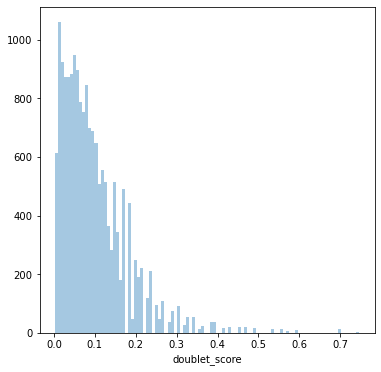

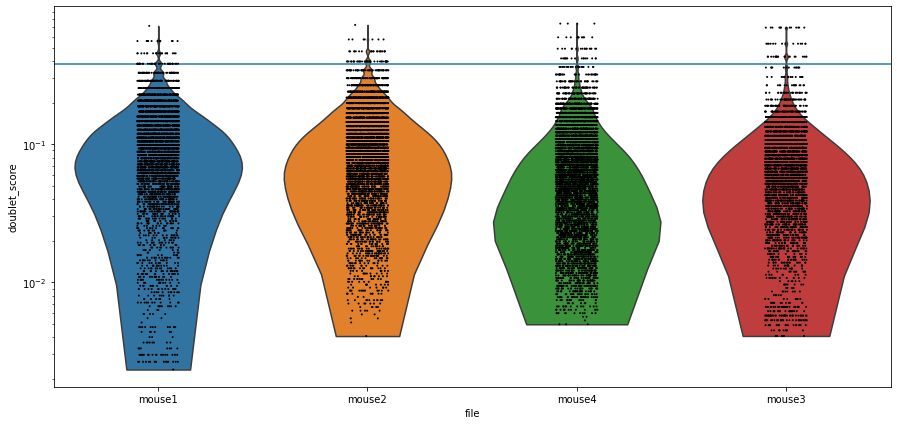

In [79]:
rcParams['figure.figsize']=(6,6)
sb.distplot(adata.obs['doublet_score'], bins=100, kde=False)
plt.show()

rcParams['figure.figsize']=(15,7)
fig,ax=plt.subplots()
sc.pl.violin(adata, 'doublet_score',
                  groupby='file',
                  size=2, log=True, cut=0,ax=ax,show=False)
DOUBLET_THR=0.38
ax.axhline(DOUBLET_THR)
plt.show()

Trying to set attribute `.obs` of view, copying.


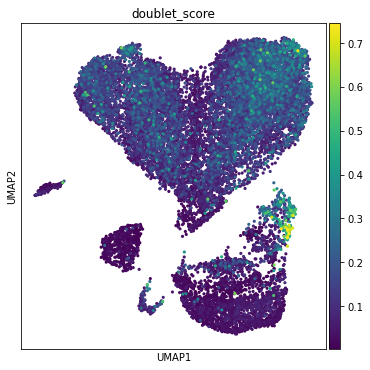

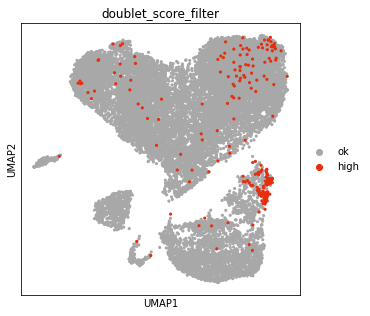

Doublet assignment: ok      17353
high      231
Name: doublet_score_filter, dtype: int64


In [78]:
# Remove cells from adata_pp that were removed before from adata
adata_pp=adata_pp[adata.obs.index]
# Plot doublet score and filtering threshold on UMAP
rcParams['figure.figsize']=(6,6)
adata_pp.obs['doublet_score']=adata.obs['doublet_score']
sc.pl.umap(adata_pp, color=['doublet_score'],size=40)
param='doublet_score'
rcParams['figure.figsize']=(5,5)
assign_high_low(adata=adata,obs_col=param,low=-np.inf,high=DOUBLET_THR)
adata_pp.obs[param+'_filter']=adata.obs[param+'_filter']
adata_pp.uns[param+'_filter_colors']=adata.uns[param+'_filter_colors']
sc.pl.umap(adata_pp[adata_pp.obs[param+'_filter'].sort_values().index,:], color=[param+'_filter'],size=40)
print('Doublet assignment:',adata.obs[param+'_filter'].value_counts())

In [80]:
print('Number of cells before doublet filter: {:d}'.format(adata.n_obs))
idx_filt = adata.obs['doublet_score']<=DOUBLET_THR

adata = adata[idx_filt].copy()
print('Number of cells after doublet filter: {:d}'.format(adata.n_obs))

Number of cells before doublet filter: 17584
Number of cells after doublet filter: 17353


## Summary after QC

In [81]:
# Summary statistics per file/batch
df = adata.obs[['n_genes','n_counts','file']]
df_all = pd.DataFrame(index=df['file'].unique())

df_all['mean_genes']=df.groupby(by='file')['n_genes'].mean()
df_all['median_genes']=df.groupby(by='file')['n_genes'].median()
df_all['mean_counts']=df.groupby(by='file')['n_counts'].mean()
df_all['median_counts']=df.groupby(by='file')['n_counts'].median()
df_all['n_cells']=df['file'].value_counts()
df_all.astype('float').round(1)

,mean_genes,median_genes,mean_counts,median_counts,n_cells
mouse1,3642.6,3853.0,29525.4,30827.0,4094.0
mouse2,3807.4,3850.0,29433.3,29455.5,4664.0
mouse4,3391.4,3473.0,22544.9,22815.0,5359.0
mouse3,3720.7,3814.0,27550.1,27523.0,3236.0


In [82]:
# Check that all filters were used properly - the min/max values are as expected
print('N counts range:',round(adata.obs['n_counts'].min(),1),'-',round(adata.obs['n_counts'].max(),1))
print('N genes range:',adata.obs['n_genes'].min(),'-',adata.obs['n_genes'].max())
print('Mt fraction range:',"{:.3e}".format(adata.obs['mt_frac'].min()),'-',"{:.3e}".format(adata.obs['mt_frac'].max()))
print('Doublet score range:',"{:.3e}".format(adata.obs['doublet_score'].min()),'-',"{:.3e}".format(adata.obs['doublet_score'].max()))
print('N cellls expressing a gene range:',adata.var['n_cells'].min(),'-',adata.var['n_cells'].max())

N counts range: 4289.0 - 86222.0
N genes range: 877 - 6854
Mt fraction range: 4.279e-03 - 9.975e-02
Doublet score range: 2.334e-03 - 3.624e-01
N cellls expressing a gene range: 20 - 17584


## Save QC data

In [83]:
# Save QC data
if SAVE:
    #adata.write(shared_folder+'data_QC.h5ad')
    h.save_h5ad(adata=adata,file=shared_folder+'data_QC.h5ad',unique_id2=UID2)
    #pickle.dump( adata, open( shared_folder+"data_QC.pkl", "wb" ) )

## Normalisation and log-scaling

In [84]:
# Load QC data
#adata=sc.read_h5ad(shared_folder+'data_QC.h5ad')
#adata=pickle.load( open( shared_folder+"data_QC.pkl", "rb" ) )
adata=h.open_h5ad(file=shared_folder+'data_QC.h5ad',unique_id2=UID2)

In [85]:
# Remove ambient genes from analysis - required if joint normalisation is performed
print('Number of genes: {:d}'.format(adata.var.shape[0]))
ambient_genes=pickle.load( open( shared_folder+"ambient_genes_selection.pkl", "rb" ) )
adata.raw=adata.copy()
adata = adata[:,np.invert(np.in1d(adata.var_names, ambient_genes))].copy()
print('Number of genes after ambient removal: {:d}'.format(adata.var.shape[0]))

Number of genes: 16445
Number of genes after ambient removal: 16430


In [86]:
adata.layers['counts'] = adata.X.copy()

In [87]:
# Data for: clustering for scran normalization in clusters and visualisation of samples on UMAP
# Make new adata_pp object that also has removed unexpressed genes 
# The adata_pp is pre-processed with normalisation to N total counts, log transformation and PC dimeni
adata_pp=adata.copy()
sc.pp.normalize_total(adata_pp, target_sum=1e6, exclude_highly_expressed=True)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['Cxcl2', 'Apoe', 'Hbb-bs', 'Mt2', 'Hba-a1', 'Hba-a2', 'Ccl2', 'Ccl4', 'Chga', 'Cd74', 'Fth1', 'Pnliprp1', 'mt-Nd1', 'mt-Nd4']
    finished (0:00:00)
computing PCA
    with n_comps=15
    finished (0:00:09)
computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:07)


Cluster cells for scran normalisation

In [88]:
# Perform clustering
sc.tl.leiden(adata_pp, key_added='groups', resolution=1)
print('N clusters:',adata_pp.obs['groups'].unique().shape[0])

running Leiden clustering
    finished: found 20 clusters and added
    'groups', the cluster labels (adata.obs, categorical) (0:00:06)
N clusters: 20


Compare samples on UMAP before scran normalisation to decide if it can be peroformed jointly or not.

In [89]:
# Calculate UMAP
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


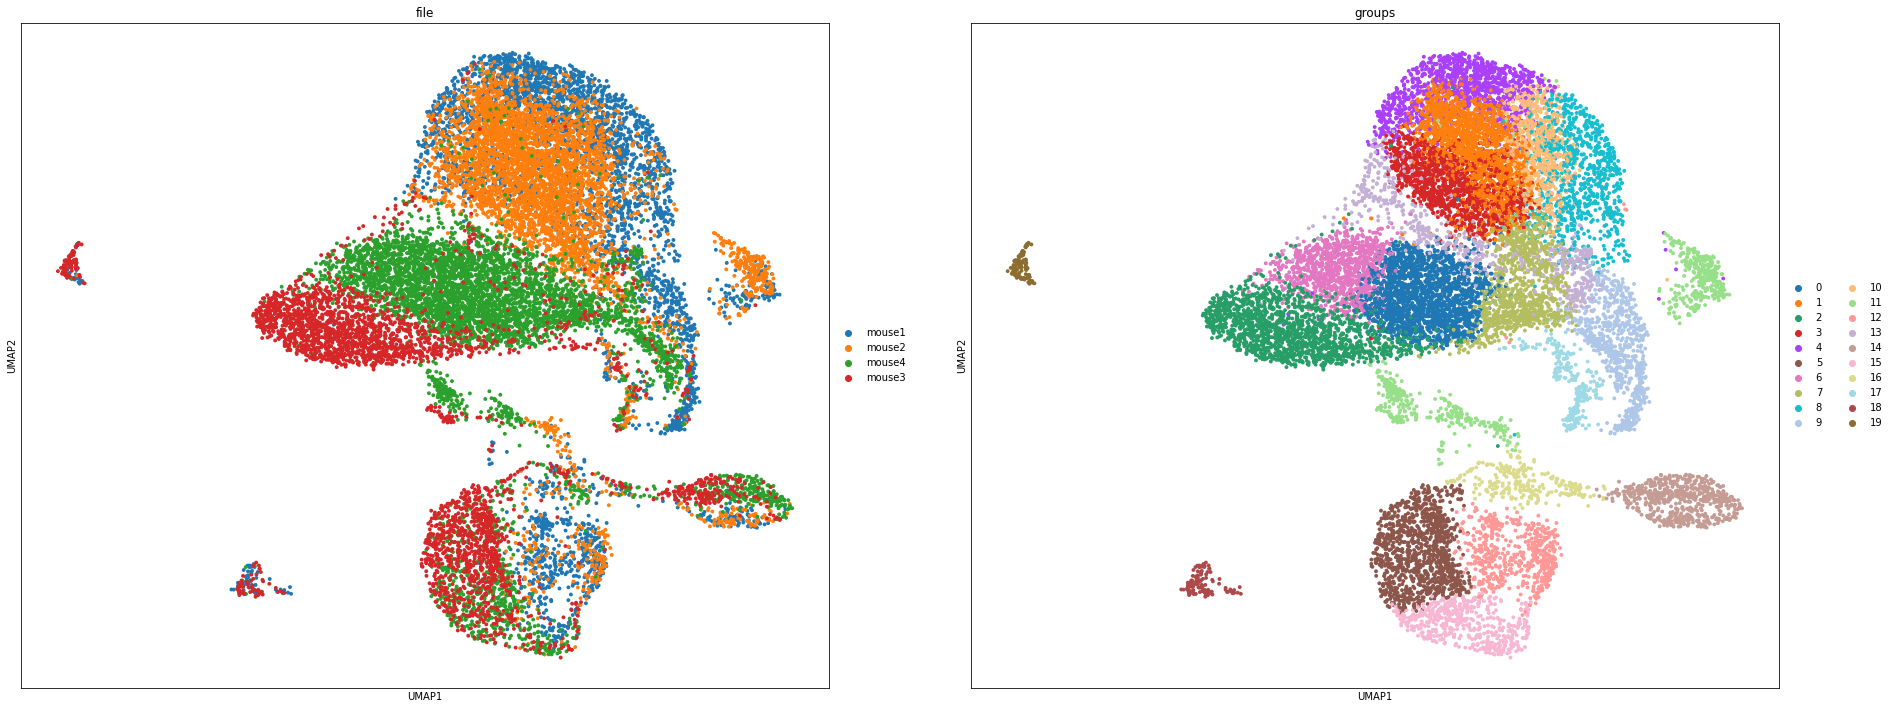

In [90]:
# Plot UMAP
rcParams['figure.figsize']=(15,12)
sc.pl.umap(adata_pp, color=['file','groups'],size=60)

Joint Scran normalisation

In [91]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [92]:
%%R -i data_mat -i input_groups -o size_factors
size_factors =  calculateSumFactors(data_mat, clusters=input_groups, min.mean=0.1,BPPARAM=MulticoreParam(workers = 8))

Distribution of size factors

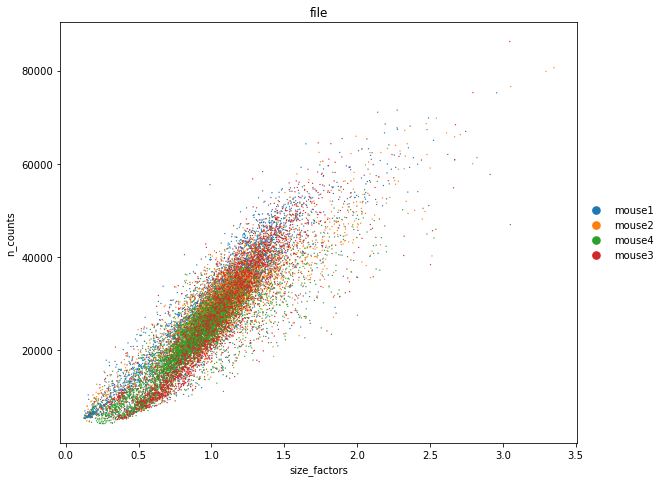

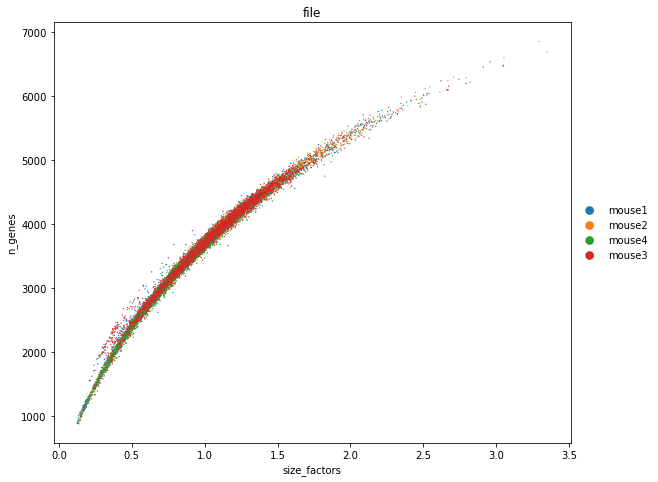

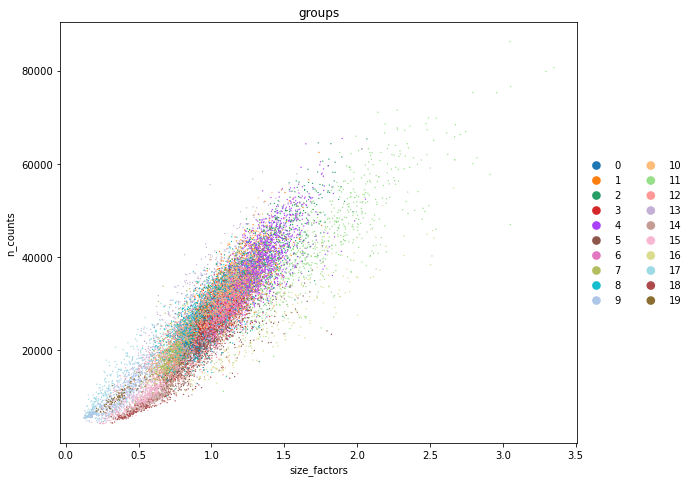

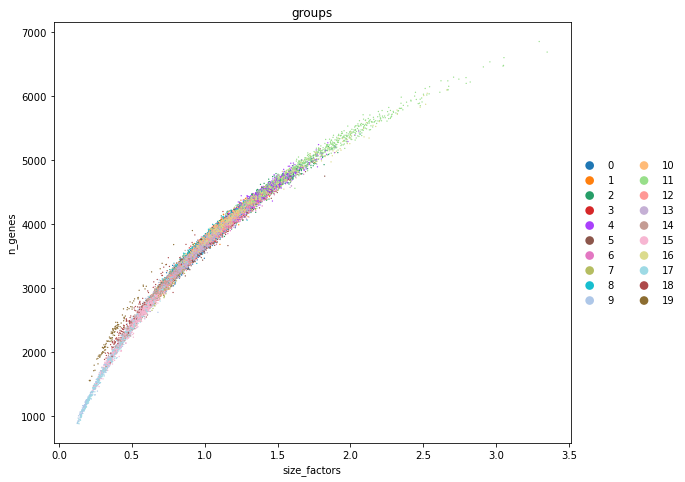

Distribution of size factors


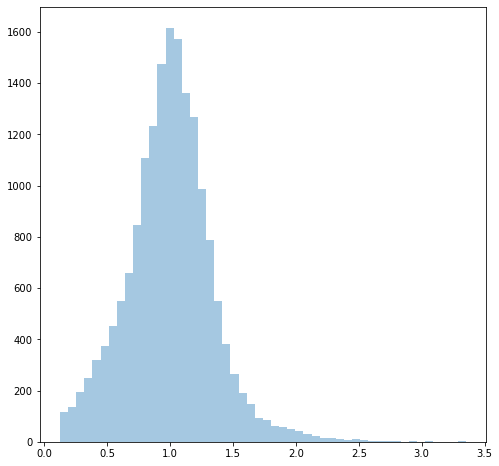

In [93]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors
adata_pp.obs['size_factors'] = size_factors

rcParams['figure.figsize']=(8,8)
sc.pl.scatter(adata, 'size_factors', 'n_counts', color='file')
sc.pl.scatter(adata, 'size_factors', 'n_genes', color='file')

#let us visualise how size factors differ across clusters
rcParams['figure.figsize']=(8,8)
#Use adata_pp here as it has obs 'group' - the n_genes and n_counts were copied from andata (counts/not normalised)
sc.pl.scatter(adata_pp, 'size_factors', 'n_counts', color='groups')
sc.pl.scatter(adata_pp, 'size_factors', 'n_genes', color='groups')

print('Distribution of size factors')
sb.distplot(size_factors, bins=50, kde=False)
plt.show()

In [94]:
# Scale data with size factors
adata.X /= adata.obs['size_factors'].values[:,None] # This reshapes the size-factors array
sc.pp.log1p(adata)
adata.X = np.asarray(adata.X)

In [95]:
del adata_pp

## Highly variable genes

Compare Seurat and CellRanger HVGs.

In [56]:
##hvg_vars=['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection']

## Seurat
#sc.pp.highly_variable_genes(adata, flavor='seurat', batch_key='file')
#n_hvg_seurat=np.sum(adata.var['highly_variable'])
#print('\n','Number of highly variable genes: {:d}'.format(n_hvg_seurat))
##hvg_seurat=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

## Same number of genes in CellRanger
#sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =n_hvg_seurat)
#print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
##hvg_cellranger=adata.var[hvg_vars]
#rcParams['figure.figsize']=(10,5)
#sc.pl.highly_variable_genes(adata)

#C: Decided for CellRanger method.

In [96]:
adata

AnnData object with n_obs × n_vars = 17353 × 16430
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'FVR', 'region', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells'
    uns: 'doublet_score_filter_colors', 'file_colors', 'mt_frac_filter_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'log1p'
    layers: 'counts'

extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)

 Number of highly variable genes: 2000


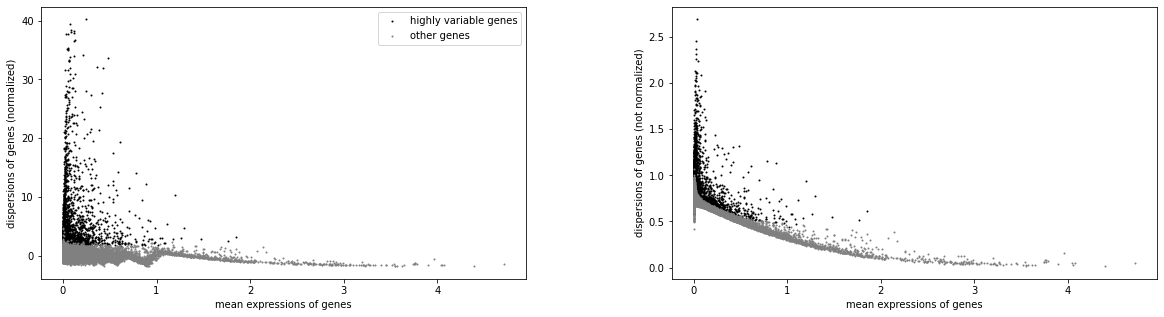

In [97]:
# Compute and plot HVG
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', batch_key='file',n_top_genes =2000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata.var['highly_variable'])))
rcParams['figure.figsize']=(10,5)
sc.pl.highly_variable_genes(adata)

#C: It seems that dispersion normalisation did not work perfectly.

In [98]:
adata

AnnData object with n_obs × n_vars = 17353 × 16430
    obs: 'file', 'n_counts', 'n_genes', 'mt_frac', 'n_counts_filter', 'n_genes_filter', 'mt_frac_filter', 'FVR', 'region', 'doublet_score', 'doublet', 'doublet_score_filter', 'size_factors'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'doublet_score_filter_colors', 'file_colors', 'mt_frac_filter_colors', 'n_counts_filter_colors', 'n_genes_filter_colors', 'log1p'
    layers: 'counts'

## Save normalised data

In [61]:
# Used due to problems with saving h5ad
#pickle.dump( adata, open( shared_folder+"data_normalised.pkl", "wb" ) )

In [99]:
if SAVE:
    #adata.write(shared_folder+"data_normalised.pkl")
    h.save_h5ad(adata=adata, file=shared_folder+"data_normalised.h5ad",unique_id2=UID2)

In [63]:
#adata_temp=adata.copy()
#adata=adata_temp.copy()

In [64]:
#adata_temp.write('/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/salinno_project/rev4/scanpy_AnnData/data_processed_temp.h5ad')